In [17]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.cm as cm
import random

from scipy.stats import norm
from scipy import misc
from matplotlib import pylab as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

%matplotlib inline

### Load and Parse Data

In [18]:
def readFile(fname):
    # ref: https://stackoverflow.com/questions/3277503/how-do-i-read-a-file-line-by-line-into-a-list
    with open(fname, 'r', errors='ignore') as f:
        content = f.readlines()
    content = [x.strip() for x in content] # remove whitespace characters
    return content

In [19]:
raw_data = readFile('./data/OFG-data.txt')

In [20]:
eruption_time = []
waiting_time = []
features = []

features = [[0 for x in range(2)] for y in range(len(raw_data))] 

for data in raw_data:
    split = data.split(',')
    eruption_time.append(float(split[0]))
    waiting_time.append(float(split[1]))

for i in range(len(raw_data)):
    features[i][0] = eruption_time[i]
    features[i][1] = waiting_time[i]

In [21]:
featuresMat = np.array(features, dtype = 'float')

### Plot Data Points

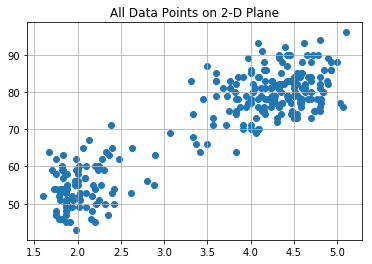

In [22]:
plt.grid()
plt.scatter(eruption_time, waiting_time)
plt.title('All Data Points on 2-D Plane')

### GMM Model

In [23]:
# ref: https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian.py

class GMM_bimodal:
    
    def __init__(self, method):
        self.method = method
        self.max_iter = 100
        self.threshold = 10**(-5)
        
    def randomInitialization(self, data):
        # randomly generate mean array
        cluster_centers_indexs = random.sample(range(len(data)), 2)
        cluster1_mean = data[cluster_centers_indexs[0]]
        cluster2_mean = data[cluster_centers_indexs[1]]
        
        # randomly generate covariance matrix
        cluster1_seed = random.uniform(0,100)
        cluster2_seed = random.uniform(0,100)
        
        cluster1_cov = [[cluster1_seed, 0], [0, cluster1_seed]]
        cluster2_cov = [[cluster2_seed, 0], [0, cluster2_seed]]
        
        # randomly generate lambda value
        lambdaValue = np.random.rand(1)[0]
        
        return cluster1_mean, cluster2_mean, cluster1_cov, cluster2_cov, lambdaValue

    def kmeansInitialization(self, data):
        # kmeans clustering
        k = 2
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        cluster_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
    
        cluster1_data = []
        cluster2_data = []
        # get cluster data
        for index in range(len(labels)):
            if labels[index] == 0:
                cluster1_data.append(data[index])
            else:
                cluster2_data.append(data[index])
        
        # assign init guess based on clustering result
        cluster1_mean = cluster_centers[0]
        cluster2_mean = cluster_centers[1]
        
        cluster1_sigmas = np.std(cluster1_data, axis = 0)
        cluster2_sigmas = np.std(cluster2_data, axis = 0)
        
        cluster1_cov = [[cluster1_sigmas[0]**2, 0], [0, cluster1_sigmas[1]**2]]
        cluster2_cov = [[cluster2_sigmas[0]**2, 0], [0, cluster2_sigmas[1]**2]]
        
        lambdaValue = len(cluster1_data)/len(data)
        
        return cluster1_mean, cluster2_mean, cluster1_cov, cluster2_cov, lambdaValue
    
    # E-step: compute responsibilities
    def computeResponsibility(self, lambdaValue, cluster1_prob, cluster2_prob):
        numerator = lambdaValue * cluster2_prob
        denominator = lambdaValue * cluster2_prob + (1 - lambdaValue) * cluster1_prob
        resp = numerator / denominator
        return resp

    def isConverged(self, old_parameters, new_parameters):
        if np.absolute(LA.norm(new_parameters[0] - old_parameters[0])) < self.threshold and np.absolute(LA.norm(new_parameters[1] - old_parameters[1])) < self.threshold:
            return True
        return False
                
    def EM(self, data):
        sampleCount, featureCount = np.shape(data)
        trajectories = []
        
        # initilization
        if self.method == 'random':
            cluster1_mean, cluster2_mean, cluster1_cov, cluster2_cov, lambdaValue = self.randomInitialization(data)
        elif self.method == 'kmeans':
            cluster1_mean, cluster2_mean, cluster1_cov, cluster2_cov, lambdaValue = self.kmeansInitialization(data)
        else:
            print('method is not supported')
            return
        
        trajectories.append([cluster1_mean, cluster2_mean])
        
        # get initial probability
        cluster1_prob = multivariate_normal.pdf(data, cluster1_mean, cluster1_cov)
        cluster2_prob = multivariate_normal.pdf(data, cluster2_mean, cluster2_cov)
        
        iteration_count = 0
        while True:
            if iteration_count > self.max_iter:
                break

            # E-step: compute responsibilities
            responsibility = self.computeResponsibility(lambdaValue, cluster1_prob, cluster2_prob)

            # M-step: compute weighted means and variances
            cluster1_mean = (1 - responsibility).dot(data) / np.sum(1 - responsibility)
            cluster1_cov = (1 - responsibility).dot((data - cluster1_mean)**2) / np.sum(1 - responsibility)
            cluster2_mean = responsibility.dot(data) / np.sum(responsibility)
            cluster2_cov = responsibility.dot((data - cluster2_mean)**2) / np.sum(responsibility)

            lambdaValue = np.sum(responsibility / sampleCount)
            cluster1_prob = multivariate_normal.pdf(data, cluster1_mean, cluster1_cov);
            cluster2_prob = multivariate_normal.pdf(data, cluster2_mean, cluster2_cov);
            
            old_parameters = trajectories[iteration_count]
            new_parameters = [cluster1_mean, cluster2_mean]

            if self.isConverged(old_parameters, new_parameters):
                break
                
            trajectories.append([cluster1_mean, cluster2_mean])
            iteration_count += 1
            
        return trajectories, iteration_count

### Testing Functions

In [30]:
def testDistributionOfIteration(method):
    distribution = []
    for i in range(50):
        gmm = GMM_bimodal(method)
        trajectories, iteration_count = gmm.EM(featuresMat)
        distribution.append(iteration_count)
    plt.grid()
    plt.hist(distribution)
    plt.title('Distribution of Total Number of Iterations - ' + method)

In [31]:
def testTrajectories(method):
    gmm = GMM_bimodal(method)
    trajectories, iteration_count = gmm.EM(featuresMat)
    trajectoriesArray = np.array(trajectories)

    plt.figure(1)
    plt.grid()
    plt.scatter(eruption_time, waiting_time)
    plt.plot(trajectoriesArray[:,0,0], trajectoriesArray[:,0,1],'o-', color="r", markersize=8, linewidth=3, label="Mean of Cluster 1")
    plt.plot(trajectoriesArray[:,1,0], trajectoriesArray[:,1,1],'o-', color="b", markersize=8, linewidth=3, label="Mean of Cluster 2")
    plt.legend(loc="best")
    plt.title('Trajectories of Two Mean Vectors - ' + method)
    
    
    plt.figure(2)
    plt.grid()
    plt.hist(iteration_count)
    plt.title('Distribution of Total Number of Iterations - ' + method)

---
## Start Working

### Single Trail - Random

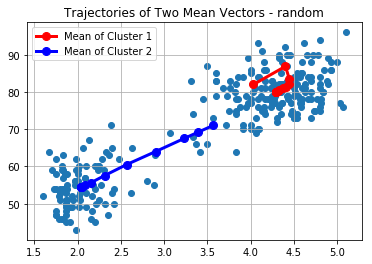

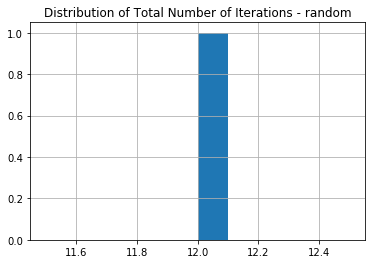

In [38]:
testTrajectories('random')

### Single Trail - K Means

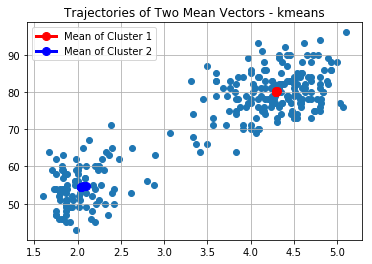

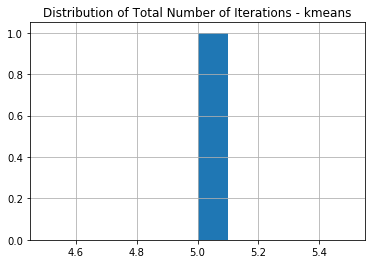

In [33]:
testTrajectories('kmeans')

### Run 50 times - Random

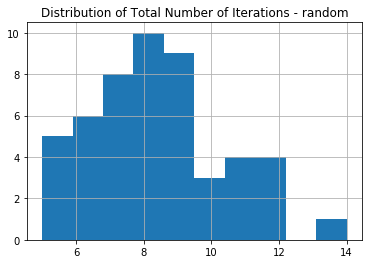

In [35]:
testDistributionOfIteration('random')

### Run 50 times - K Means

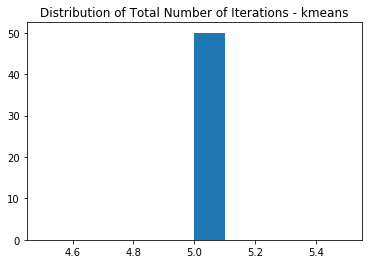

In [29]:
testDistributionOfIteration('kmeans')